<a href="https://colab.research.google.com/github/Shashank-Girish/FinancialNewsSentimentAnalysis/blob/main/ML_Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
from google.colab import drive

# Load your dataset (assuming you have 'text' and 'label' columns)
# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset (adjust the file path as needed)
file_path = '/content/drive/My Drive/IndianFinancialNews.csv'
df = pd.read_csv(file_path)

# Check the dataset structure
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Date,Title,Description
0,0,"May 26, 2020, Tuesday","ATMs to become virtual bank branches, accept d...","Close to 14.6 per cent (or 35,000) of the 240,..."
1,1,"May 26, 2020, Tuesday",IDFC First Bank seniors to forgo 65% of bonus ...,"V Vaidyanathan, managing director and chief ex..."
2,2,"May 25, 2020, Monday","Huge scam in YES Bank for many years, says Enf...",Rana Kapoor's wife also charged with abetting ...
3,3,"May 24, 2020, Sunday","Bank of Maharashtra sanctioned Rs 2,789 cr in ...",The bank said it was now gearing up to extend ...
4,4,"May 23, 2020, Saturday",DCB Bank's profit before tax declines 37.6% to...,Net profit for the financial year ended March ...


In [3]:
# Remove rows with missing values in relevant columns
df.dropna(subset=['Title', 'Description'], inplace=True)

# Define a function to clean text (remove URLs, punctuation, etc.)
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning to 'title' and 'description'
df['cleaned_description'] = df['Description'].apply(clean_text)

# Check cleaned data
df[['Description', 'cleaned_description']].head()

,Description,cleaned_description
0,"Close to 14.6 per cent (or 35,000) of the 240,...",close to 146 per cent or 35000 of the 240000 a...
1,"V Vaidyanathan, managing director and chief ex...",v vaidyanathan managing director and chief exe...
2,Rana Kapoor's wife also charged with abetting ...,rana kapoors wife also charged with abetting c...
3,The bank said it was now gearing up to extend ...,the bank said it was now gearing up to extend ...
4,Net profit for the financial year ended March ...,net profit for the financial year ended march ...


In [4]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function for VADER sentiment
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    return 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral'

# Define function for TextBlob sentiment
def get_textblob_sentiment(text):
    score = TextBlob(text).sentiment.polarity
    return 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'

# Apply sentiment functions to 'cleaned_description' column
df['vader_sentiment'] = df['cleaned_description'].apply(get_vader_sentiment)
df['textblob_sentiment'] = df['cleaned_description'].apply(get_textblob_sentiment)

# Filter rows where VADER and TextBlob sentiments match
df = df[df['vader_sentiment'] == df['textblob_sentiment']].copy()

# Map labels to numeric values
label_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['label'] = df['vader_sentiment'].map(label_map)

# Check the resulting dataframe
df[['cleaned_description', 'vader_sentiment', 'textblob_sentiment', 'label']].head()


,cleaned_description,vader_sentiment,textblob_sentiment,label
0,close to 146 per cent or 35000 of the 240000 a...,neutral,neutral,0
6,hdfc bank cuts base rate by 55 bps sbi calls a...,negative,negative,-1
11,enquiries for fresh loans see uptick,positive,positive,1
15,loans sanctioned by public sector banks psbs a...,neutral,neutral,0
16,senior bank executives said the indian banks a...,neutral,neutral,0


In [5]:
# Prepare tokenizer
tokenizer = Tokenizer(num_words=5000)  # Adjust vocabulary size
tokenizer.fit_on_texts(df['cleaned_description'])
sequences = tokenizer.texts_to_sequences(df['cleaned_description'])

# Pad sequences for uniform input size
max_sequence_len = 100  # Adjust based on your data
X = pad_sequences(sequences, maxlen=max_sequence_len)
y = to_categorical(df['label'])  # One-hot encode labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, SpatialDropout1D, GRU

# Define model parameters
vocab_size = 5000  # Same as in Tokenizer
embedding_dim = 128
cnn_filters = 64
kernel_size = 5
lstm_units = 64
num_classes = y.shape[1]  # Number of sentiment categories (e.g., 3 for positive, neutral, negative)

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_len),
    SpatialDropout1D(0.2),  # Helps prevent overfitting
    Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(lstm_units, return_sequences=True),  # RNN layer, can use GRU as an alternative
    LSTM(lstm_units),
    Dropout(0.5),
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,  # Adjust based on your dataset
    batch_size=64,
    validation_split=0.2,  # 20% of the training data used for validation
    verbose=1
)


Epoch 1/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - accuracy: 0.7358 - loss: 0.4746 - val_accuracy: 0.9679 - val_loss: 0.1107
Epoch 2/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.9854 - loss: 0.0576 - val_accuracy: 0.9748 - val_loss: 0.0910
Epoch 3/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.9920 - loss: 0.0328 - val_accuracy: 0.9751 - val_loss: 0.1049
Epoch 4/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9952 - loss: 0.0194 - val_accuracy: 0.9729 - val_loss: 0.1291
Epoch 5/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.9974 - loss: 0.0124 - val_accuracy: 0.9687 - val_loss: 0.1576
Epoch 6/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 165ms/step - accuracy: 0.9970 - loss: 0.0115 - val_accuracy: 0.9720 - val_loss: 0.1386
Epoch 7/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - accuracy: 0.9975 - loss: 0.0089 - val_accuracy: 0.9693 - val_loss: 0.1826
Epoch 8/15
226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.9997 - loss: 0

In [8]:
# Evaluate the RNN model
loss, accuracy = model.evaluate(X, y)
print("RNN Model Accuracy:", accuracy)

706/706 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9891 - loss: 0.0848
RNN Model Accuracy: 0.9897258877754211


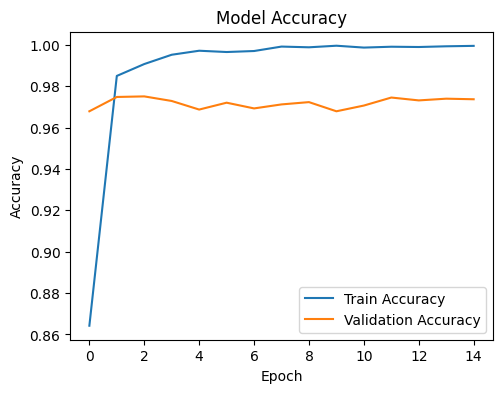

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()
